# Passivation of Silicon Nanowire

## 0. Introduction.

In this notebook, we will demonstrate how to passivate a Silicon Nanowire using the Coordination Based Passivation Builder. The passivation is based on the coordination number of the atoms in the material. The passivation builder will saturate the bonds of the atoms with a coordination number below a certain threshold. The threshold can be set interactively or manually.
Following the publication:

> **B. Aradi, L. E. Ramos, P. Deák, Th. Köhler, F. Bechstedt, R. Q. Zhang, and Th. Frauenheim**,
> Theoretical study of the chemical gap tuning in silicon nanowires
> Phys. Rev. B 76, 035305 (2007)
> DOI: [10.1103/PhysRevB.76.035305](https://doi.org/10.1103/PhysRevB.76.035305)


This notebook will focus on recreating the material from Fig. 1. (Silicon nanowire passivated with hydrogen):

<img src="https://i.imgur.com/StKnrzu.png" alt="Silicon Nanowire Passivated with Hydrogen" width="400"/>

## 1. Prepare the environment
### 1.1. Set up the notebook

In [100]:
# Enable interactive selection of coordination threshold
IS_COORDINATION_SELECTION_INTERACTIVE = False

BOND_LENGTH = 1.46 # in Angstroms
PASSIVANT = "H" # Chemical symbol of the passivant
COORDINATION_SEARCH_RADIUS = 2.5 # in Angstroms (sphere in which to search for neighbors)
COORDINATION_THRESHOLD = 3 # Coordination number below which to passivate
MAX_BONDS_TO_SATURATE = 2 # Maximum number of bonds to saturate

 ### 1.2. Install packages
The step executes only in Pyodide environment. For other environments, the packages should be installed via `pip install` (see [README](../../README.ipynb)).

In [101]:
import sys

if sys.platform == "emscripten":
    import micropip

    await micropip.install('mat3ra-api-examples', deps=False)
    from utils.jupyterlite import install_packages

    await install_packages("specific_examples")

## 2. Create the Silicon Nanowire
### 2.1. Get input material
Import the Silicon from Standata

In [102]:
from mat3ra.standata.materials import Materials
from mat3ra.made.material import Material

silicon = Material(Materials.get_by_name_first_match('Silicon'))

### 2.2. Create a silicon nanowire

In [133]:
from mat3ra.made.tools.build.supercell import create_supercell
from mat3ra.made.tools.modify import rotate, filter_by_box, add_vacuum_sides
from mat3ra.made.tools.build.slab import create_slab, SlabConfiguration

slab_config = SlabConfiguration(bulk=silicon, miller_indices=(1,1,0), thickness=2, vacuum=0, use_orthogonal_z=True, use_conventional_cell=True, xy_supercell_matrix=[[3,0],[0,2]], make_primitive=False) 
silicon_slab = create_slab(slab_config)
visualize_materials([{"material": silicon_slab}, {"material": silicon_slab, "rotation": "-90x"}])

supercell = create_supercell(silicon, scaling_factor=[3,3,3])
visualize_materials([{"material": supercell}, {"material": supercell, "rotation": "-90x"}])
# slab_config_2 = SlabConfiguration(bulk=silicon_slab, miller_indices=(0,0,1), thickness=4, vacuum=0, use_orthogonal_z=True, use_conventional_cell=False, xy_supercell_matrix=[[3,0],[0,3]], make_primitive=False)
# silicon_slab = create_slab(slab_config_2)
# silicon_slab = create_supercell(silicon_slab, scaling_factor= [1,1,1])
nanowire_xy_pbc = add_vacuum_sides(silicon_slab, 10.0, on_x=True, on_y=True)

GridBox(children=(VBox(children=(Label(value='Si96 - Material - rotation: 0x,0y,0z', layout=Layout(align_self=…

GridBox(children=(VBox(children=(Label(value='Si54 - Material - rotation: 0x,0y,0z', layout=Layout(align_self=…

### 2.3. Visualize the Material

In [122]:
from utils.visualize import visualize_materials

visualize_materials([{"material": nanowire_xy_pbc}, {"material": nanowire_xy_pbc, "rotation": "-90x"}])
set_materials([nanowire_xy_pbc])

GridBox(children=(VBox(children=(Label(value='Si192 - Material - rotation: 0x,0y,0z', layout=Layout(align_self…

Data for materials written to uploads/Si8(110), termination Si_Pmma_4, Slab.json


### 2.4. Compute the radial distribution function (RDF) of the Material

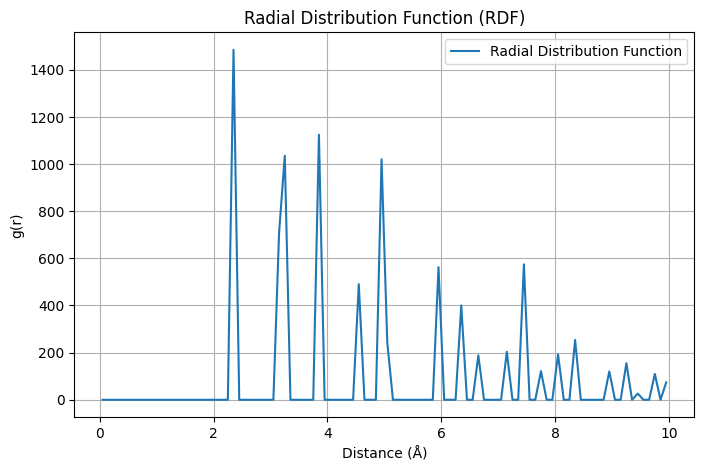

In [105]:
from utils.plot import plot_rdf

plot_rdf(nanowire_xy_pbc, cutoff=10.0)

## 3. Create passivated material
### 3.1. Set the passivation parameters including the coordination threshold

In [106]:
from utils.io import select_coordination_threshold
from mat3ra.made.tools.build.passivation import get_unique_coordination_numbers, PassivationConfiguration
from mat3ra.made.tools.build.passivation.builders import CoordinationBasedPassivationBuilder, \
    CoordinationBasedPassivationBuilderParameters

config = PassivationConfiguration(
    slab=nanowire_xy_pbc,
    passivant=PASSIVANT,
    bond_length=BOND_LENGTH
)
builder_params = CoordinationBasedPassivationBuilderParameters(
    shadowing_radius=COORDINATION_SEARCH_RADIUS,
    coordination_threshold=0,
)
passivation_builder = CoordinationBasedPassivationBuilder(builder_params)

coordination_numbers     = sorted(list(passivation_builder.get_unique_coordination_numbers(nanowire_xy_pbc)))
print(f"Unique coordination numbers: {coordination_numbers}")
coordination_numbers = sorted(list(get_unique_coordination_numbers(config, builder_params)))
print(f"Unique coordination numbers: {coordination_numbers}")

coordination_threshold = COORDINATION_THRESHOLD
if IS_COORDINATION_SELECTION_INTERACTIVE:
    coordination_threshold = await select_coordination_threshold(coordination_numbers, COORDINATION_THRESHOLD)

Unique coordination numbers: [1, 2, 3]
Unique coordination numbers: [1, 2, 3]


### 3.2. Create the passivated material

In [107]:
from mat3ra.made.tools.build.passivation import CoordinationBasedPassivationBuilderParameters, CoordinationBasedPassivationBuilder, create_passivation
params = CoordinationBasedPassivationBuilderParameters(
    shadowing_radius=COORDINATION_SEARCH_RADIUS, 
    coordination_threshold=coordination_threshold,    
    bonds_to_passivate=MAX_BONDS_TO_SATURATE
)

passivation_builder = CoordinationBasedPassivationBuilder(params)
passivated_nanowire = create_passivation(config, passivation_builder)

## 4. Preview the Material

In [108]:
visualize_materials([{"material": passivated_nanowire}, {"material": passivated_nanowire, "rotation": "-90x"}])

GridBox(children=(VBox(children=(Label(value='H80Si72 - Material - rotation: 0x,0y,0z', layout=Layout(align_se…

## 5. Download the Material

In [109]:
from utils.jupyterlite import download_content_to_file, set_materials
passivated_nanowire.name = "H-Passivated Silicon Nanowire"
download_content_to_file(passivated_nanowire, "passivated_nanowire.xyz")
set_materials([passivated_nanowire])

<IPython.core.display.Javascript object>

Data for materials written to uploads/H-Passivated Silicon Nanowire.json
